Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
!pip install hydra-core --upgrade

In [4]:
from src.commands import *
import hydra

hydra.core.global_hydra.GlobalHydra.instance().clear()
CONF = hydra_config()
show_CONF(CONF)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.999,
                "pos_aug": 22,
                "neg_aug": 2
        },
        "loader": {
                "batch_size": 8
        },
        "siamese": {
                "n_epochs": 5,
                "learning_rate": 0.001,
                "margin": 9,
                "train": true,
                "path_model": "siamese",
                "path_log": "siamese.pickle"
        },
        "classifier": {
                "n_epochs": 5,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "classifier",
                "path_log": "classifier.pickle"
        }
}


In [5]:
show_CONF(CONF)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.999,
                "pos_aug": 22,
                "neg_aug": 2
        },
        "loader": {
                "batch_size": 8
        },
        "siamese": {
                "n_epochs": 5,
                "learning_rate": 0.001,
                "margin": 9,
                "train": true,
                "path_model": "siamese",
                "path_log": "siamese.pickle"
        },
        "classifier": {
                "n_epochs": 5,
                "learning_rate": 0.0001,
                "train": true,
                "path_model": "classifier",
                "path_log": "classifier.pickle"
        }
}


# Библиотеки

In [6]:
from hydra import compose, initialize
from omegaconf import OmegaConf
import json, os
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import os, json, cv2, re
import numpy as np

from src.dataset import My_Dataset, TripletDataset, Emb_Dataset
from src.functions import number_of_parameters, seed_everything, create_model
from src.dataset_fun import split_dataset
from src import siamese, classifier
from src.train import train, load_logs, load_model

# train

[**TripletMarginLoss**
](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html)

$L(a,p,n)=max\{d(ai​,pi​)−d(ai​,ni​) + margin,0\}$

$d(x_i, y_i) = \|x_i − y_i\|p$

[Contrastive learning](https://www.v7labs.com/blog/contrastive-learning-guide#:~:text=Contrastive%20Learning%20is%20a%20technique,a%20data%20class%20from%20another.)

[Contrastive learning](https://colab.research.google.com/drive/1uvXs3P1XsH7Mtc20kEI2D9cAPcg-cjyw?usp=sharing#scrollTo=_mmDxSSu19_e)

[Cиамские сети](https://habr.com/ru/articles/794750/)

[Cиамские сети](https://habr.com/ru/companies/jetinfosystems/articles/465279/)



In [7]:
# a = torch.tensor(
#     [[ 0.2035,  1.2959,  1.8101, -0.4644],
#      [ 1.5027, -0.3270,  0.5905,  0.6538],
#      [-1.5745,  1.3330, -0.5596, -0.6548],
#      [ 0.1264, -0.5080,  1.6420,  0.1992]])
# torch.std(a).item()

In [8]:
from torchvision import models, transforms

pos_dataset, neg_dataset = pos_neg_dataset(CONF)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_classes = 1000
num_non_freeze = 513000
seed_everything(CONF.seed)
model = create_model(model, num_non_freeze, num_classes).to(CONF.device)
print(f"num parameters ResNet = {number_of_parameters(model)}")

dataset1 = TripletDataset(
        pos_dataset, neg_dataset, required_len=1000, deterministic=True, seed=CONF.seed
    )
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset1)

common_train(CONF, model, train_dataset, test_dataset, kind="siam")
load_best_model(CONF, model, train_dataset, test_dataset, kind="siam")

Positive dataset: 484    (22)
Negative dataset: 448    (224)
num parameters ResNet = 513000
split_dataset: Train: 800 Test: 200 Total: 1000
train: started, kind = 'siam'
# 2024-05-28 11:27:39 Epoch 1 train/val: loss 3.34628/4.90976, acc: 88.625%/ 75.000%
# 2024-05-28 11:27:47 Epoch 2 train/val: loss 2.09117/3.96242, acc: 93.875%/ 81.500%
# 2024-05-28 11:27:54 Epoch 3 train/val: loss 1.26897/3.03909, acc: 97.250%/ 91.000%
# 2024-05-28 11:28:02 Epoch 4 train/val: loss 0.90004/2.77425, acc: 98.250%/ 91.500%
# 2024-05-28 11:28:10 Epoch 5 train/val: loss 0.71966/2.35579, acc: 98.750%/ 92.000%
# Время работы: 00:00:41
load_best_model:
LOGS:
# 2024-05-28 11:28:10 Epoch 5 train/val: loss 0.71966/2.35579, acc: 98.750%/ 92.000%
MODEL:
# 2024-05-28 11:28:14 Epoch 5 train/val: loss 0.71966/2.35579, acc: 98.750%/ 92.000%


In [9]:
cl = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), nn.Linear(512, 2)).to(
    CONF.device
)
num_param = number_of_parameters(cl)
print(f"num parameters = {num_param}")

dataset2 = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
dataset2 = Emb_Dataset(model, dataset2, CONF.device)
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset2)

common_train(CONF, cl, train_dataset, test_dataset, kind="cl")
load_best_model(CONF, cl, train_dataset, test_dataset, kind="cl")

num parameters = 513538
split_dataset: Train: 745 Test: 187 Total: 932
train: started, kind = 'cl'
# 2024-05-28 11:28:21 Epoch 1 train/val: loss 0.39355/0.44195, acc: 83.758%/ 82.888%
# 2024-05-28 11:28:26 Epoch 2 train/val: loss 0.31381/0.36247, acc: 89.530%/ 85.561%
# 2024-05-28 11:28:32 Epoch 3 train/val: loss 0.34023/0.39249, acc: 86.309%/ 82.888%
# 2024-05-28 11:28:37 Epoch 4 train/val: loss 0.24395/0.30593, acc: 92.617%/ 89.305%
# 2024-05-28 11:28:42 Epoch 5 train/val: loss 0.22282/0.31921, acc: 91.544%/ 87.166%
# Время работы: 00:00:27
load_best_model:
LOGS:
# 2024-05-28 11:28:42 Epoch 4 train/val: loss 0.24395/0.30593, acc: 92.617%/ 89.305%
MODEL:
# 2024-05-28 11:28:48 Epoch 4 train/val: loss 0.24409/0.30593, acc: 92.617%/ 89.305%


In [ ]:
logs = load_logs(os.path.join(CONF.save_path, CONF.siamese.path_log))

In [ ]:
epoch = logs['epoch'][np.array(logs['val_accuracy']).argmax()]
epoch

9

In [ ]:
load_model(model, epoch, os.path.join(CONF.save_path, CONF.siamese.path_model), CONF.device)

In [ ]:
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(dataset)
train_loader = DataLoader(
    train_dataset, batch_size=CONF.loader.batch_size, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=CONF.loader.batch_size, shuffle=False
)
loss_fn = nn.TripletMarginLoss(margin=CONF.siamese.margin, p=2)

acc, loss = siamese.eval_epoch(model, train_loader, loss_fn, CONF.device)
print(acc, loss)
acc, loss = siamese.eval_epoch(model, test_loader, loss_fn, CONF.device)
print(acc, loss)
# 0.99875 0.07791236162185669
# 0.99 0.8073829650878906

split_dataset:
Train: 800
Test: 200
Total: 1000
0.995 0.32544512510299684
0.945 1.979416046142578


In [ ]:
def graph2(x, y1, y2, title="", ylog=True):
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=13)

    plt.plot(x, y1, color='g', label = "Train")
    plt.plot(x, y2, color='m', label = "Test")

    plt.grid(True)
    plt.ylabel("loss",  fontsize=10)
    plt.xlabel("Номер итерации",  fontsize=10)

    if ylog:
        plt.yscale('log')

    plt.legend(fontsize=10)

    plt.show()

In [ ]:
# graph2(logs['epoch'], logs['train_loss'], logs['val_loss'], title="")

In [ ]:
# graph2(logs['epoch'], logs['train_accuracy'], logs['val_accuracy'], ylog = False)

In [ ]:
dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
emb_dataset = Emb_Dataset(model, dataset, CONF.device)

seed_everything(CONF.seed)
cl = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), nn.Linear(512, 2)).to(
    CONF.device
)

num_param = number_of_parameters(cl)
print(f"num parameters = {num_param}")

print("Classifier loop started!!!")
loop(CONF, cl, emb_dataset, kind="cl")
print("Classifier loop done!!!")

num parameters = 513538
Classifier loop started!!!
split_dataset:
Train: 745
Test: 187
Total: 932
train: started, kind = 'cl'
# 2024-05-27 20:36:27 Epoch 1 train/val: loss 0.37592/0.44852, acc:  85.235%/ 82.888%
# 2024-05-27 20:36:33 Epoch 2 train/val: loss 0.29526/0.37754, acc:  89.128%/ 84.492%
# 2024-05-27 20:36:39 Epoch 3 train/val: loss 0.29514/0.39852, acc:  90.470%/ 82.888%
# 2024-05-27 20:36:44 Epoch 4 train/val: loss 0.21596/0.32927, acc:  95.168%/ 87.701%
# 2024-05-27 20:36:50 Epoch 5 train/val: loss 0.19383/0.32522, acc:  93.826%/ 86.631%
# Время работы: 00:00:28
Classifier loop done!!!


In [ ]:
# 2024-05-27 20:31:44 Epoch 1 train/val: loss 0.37610/0.44884, acc:  85.101%/ 83.422%
# 2024-05-27 20:31:52 Epoch 2 train/val: loss 0.29554/0.37774, acc:  89.128%/ 85.027%
# 2024-05-27 20:32:00 Epoch 3 train/val: loss 0.29537/0.39972, acc:  90.604%/ 82.888%
# 2024-05-27 20:32:06 Epoch 4 train/val: loss 0.21593/0.32829, acc:  95.034%/ 87.701%
# 2024-05-27 20:32:11 Epoch 5 train/val: loss 0.19455/0.32558, acc:  93.557%/ 86.631%

In [ ]:
load_model(cl, 4, os.path.join(CONF.save_path, CONF.classifier.path_model), CONF.device)

In [ ]:
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(emb_dataset)
train_loader = DataLoader(
    train_dataset, batch_size=CONF.loader.batch_size, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=CONF.loader.batch_size, shuffle=False
)
loss_fn = torch.nn.CrossEntropyLoss()

acc, loss = classifier.eval_epoch(cl, train_loader, loss_fn, CONF.device)
print(acc, loss)
acc, loss = classifier.eval_epoch(cl, test_loader, loss_fn, CONF.device)
print(acc, loss)

split_dataset:
Train: 745
Test: 187
Total: 932
0.95167786 0.2165640449904381
0.87700534 0.32926773093640804


In [ ]:
# pos_dataset, neg_dataset, model, cl = main(CONF)

Positive dataset: 220    (22)
Negative dataset: 448    (224)
num_non_freeze = 513000/11689512
num parameters ResNet = 513000
ResNet loop started!!!
split_dataset:
Train: 800
Test: 200
Total: 1000
train: started, kind = 'siam'


  0%|          | 0/20 [00:00<?, ?it/s]

# 2024-05-27 15:27:09 Epoch  1 train/val: loss 3.04131/4.67343, acc: 92.250%/82.000%


 10%|█         | 2/20 [00:21<03:05, 10.30s/it]

# 2024-05-27 15:27:18 Epoch  2 train/val: loss 1.43045/2.94396, acc: 97.375%/89.000%


 15%|█▌        | 3/20 [00:29<02:36,  9.21s/it]

# 2024-05-27 15:27:26 Epoch  3 train/val: loss 0.91769/2.63139, acc: 98.500%/92.500%


 20%|██        | 4/20 [00:36<02:18,  8.66s/it]

# 2024-05-27 15:27:34 Epoch  4 train/val: loss 0.62531/2.05966, acc: 99.500%/94.000%


 25%|██▌       | 5/20 [00:44<02:06,  8.44s/it]

# 2024-05-27 15:27:42 Epoch  5 train/val: loss 0.39496/1.91581, acc: 99.500%/95.000%


 30%|███       | 6/20 [00:52<01:56,  8.29s/it]

# 2024-05-27 15:27:50 Epoch  6 train/val: loss 0.31751/1.83445, acc: 99.750%/95.000%


 35%|███▌      | 7/20 [01:00<01:46,  8.18s/it]

# 2024-05-27 15:27:58 Epoch  7 train/val: loss 0.29071/1.60721, acc: 99.750%/96.000%


 40%|████      | 8/20 [01:08<01:37,  8.12s/it]

# 2024-05-27 15:28:06 Epoch  8 train/val: loss 0.28362/1.48413, acc: 99.750%/96.000%


 45%|████▌     | 9/20 [01:16<01:28,  8.02s/it]

# 2024-05-27 15:28:14 Epoch  9 train/val: loss 0.17355/1.32284, acc: 100.000%/95.500%


 50%|█████     | 10/20 [01:24<01:19,  7.97s/it]

# 2024-05-27 15:28:21 Epoch 10 train/val: loss 0.14482/1.18729, acc: 99.750%/97.500%


 55%|█████▌    | 11/20 [01:32<01:12,  8.11s/it]

# 2024-05-27 15:28:30 Epoch 11 train/val: loss 0.12450/1.29091, acc: 99.750%/98.000%


 60%|██████    | 12/20 [01:40<01:04,  8.02s/it]

# 2024-05-27 15:28:38 Epoch 12 train/val: loss 0.10749/1.13043, acc: 100.000%/97.000%


 65%|██████▌   | 13/20 [01:48<00:55,  7.99s/it]

# 2024-05-27 15:28:46 Epoch 13 train/val: loss 0.11219/1.09657, acc: 100.000%/96.000%


 70%|███████   | 14/20 [01:56<00:47,  7.95s/it]

# 2024-05-27 15:28:53 Epoch 14 train/val: loss 0.11037/0.99481, acc: 99.875%/98.000%


 75%|███████▌  | 15/20 [02:04<00:39,  7.95s/it]

# 2024-05-27 15:29:01 Epoch 15 train/val: loss 0.08306/0.91392, acc: 99.875%/97.500%


 80%|████████  | 16/20 [02:12<00:31,  7.90s/it]

# 2024-05-27 15:29:09 Epoch 16 train/val: loss 0.16062/1.03639, acc: 99.750%/96.000%


 85%|████████▌ | 17/20 [02:20<00:23,  7.92s/it]

# 2024-05-27 15:29:17 Epoch 17 train/val: loss 0.07791/0.80738, acc: 99.875%/99.000%


 90%|█████████ | 18/20 [02:27<00:15,  7.88s/it]

# 2024-05-27 15:29:25 Epoch 18 train/val: loss 0.10639/1.07759, acc: 99.750%/97.500%


 95%|█████████▌| 19/20 [02:35<00:07,  7.89s/it]

# 2024-05-27 15:29:33 Epoch 19 train/val: loss 0.10375/0.83818, acc: 99.875%/97.000%


100%|██████████| 20/20 [02:43<00:00,  8.19s/it]

# 2024-05-27 15:29:41 Epoch 20 train/val: loss 0.07109/0.77985, acc: 99.875%/97.000%
# Время работы: 00:02:43


ResNet loop done!!!
num parameters = 513538
Classifier loop started!!!
split_dataset:
Train: 534
Test: 134
Total: 668
train: started, kind = 'cl'


 20%|██        | 1/5 [00:04<00:17,  4.38s/it]

# 2024-05-27 15:29:45 Epoch 1 train/val: loss 0.26331/0.31503, acc: 91.760%/89.552%


 40%|████      | 2/5 [00:08<00:12,  4.10s/it]

# 2024-05-27 15:29:49 Epoch 2 train/val: loss 0.20693/0.29894, acc: 93.446%/85.821%


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

# 2024-05-27 15:29:53 Epoch 3 train/val: loss 0.17403/0.28065, acc: 94.569%/88.060%


 80%|████████  | 4/5 [00:16<00:04,  4.14s/it]

# 2024-05-27 15:29:58 Epoch 4 train/val: loss 0.13027/0.25231, acc: 97.753%/88.060%


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]

# 2024-05-27 15:30:01 Epoch 5 train/val: loss 0.11482/0.26610, acc: 97.940%/85.821%
# Время работы: 00:00:20
Classifier loop done!!!


In [ ]:
# seed: 42
# device: cuda

# dataset:
#     data_pos: bin/1
#     data_neg: bin/0
#     threshold: 0.999 # доля белого
#     pos_aug: 22
#     neg_aug: 2

# loader:
#     batch_size: 8

# siam:
#     n_epochs: 31
#     learning_rate: 1e-3
#     path: m.pth

# classifier:
#     n_epochs: 15
#     learning_rate: 1e-4
#     path: c.pth


In [ ]:
# Positive dataset: 484    (22)
# Negative dataset: 448    (224)
# num_non_freeze = 513000/11689512
# num parameters ResNet = 513000
# ResNet loop started!!!
# split_dataset:
# Train: 800
# Test: 200
# Total: 1000
# train_siam: started
# # Epoch  1/31 train/val: loss 3.34628/4.90976, accuracy: 88.625%/75.000%
# # Epoch  2/31 train/val: loss 2.09117/3.96242, accuracy: 93.875%/81.500%
# # Epoch  3/31 train/val: loss 1.26897/3.03909, accuracy: 97.250%/91.000%
# # Epoch  4/31 train/val: loss 0.90004/2.77425, accuracy: 98.250%/91.500%
# # Epoch  5/31 train/val: loss 0.71966/2.35579, accuracy: 98.750%/92.000%
# # Epoch  6/31 train/val: loss 0.46670/2.20316, accuracy: 99.625%/93.000%
# # Epoch  7/31 train/val: loss 0.40910/2.31501, accuracy: 99.625%/93.000%
# # Epoch  8/31 train/val: loss 0.37197/2.07717, accuracy: 99.250%/93.000%
# # Epoch  9/31 train/val: loss 0.32545/1.97942, accuracy: 99.500%/94.500%
# # Epoch 10/31 train/val: loss 0.22992/1.78900, accuracy: 99.625%/93.500%
# # Epoch 11/31 train/val: loss 0.25119/1.84785, accuracy: 99.750%/93.500%
# # Epoch 12/31 train/val: loss 0.30351/1.90883, accuracy: 99.375%/92.000%
# # Epoch 13/31 train/val: loss 0.25803/1.95259, accuracy: 99.625%/92.500%
# # Epoch 14/31 train/val: loss 0.18939/1.90380, accuracy: 99.500%/93.000%
# # Epoch 15/31 train/val: loss 0.14175/1.75823, accuracy: 99.875%/94.000%
# # Epoch 16/31 train/val: loss 0.22874/1.86755, accuracy: 99.125%/91.000%
# # Epoch 17/31 train/val: loss 0.16902/1.89906, accuracy: 99.500%/90.000%
# # Epoch 18/31 train/val: loss 0.19044/1.74014, accuracy: 99.750%/92.500%
# # Epoch 19/31 train/val: loss 0.26009/2.14008, accuracy: 99.125%/92.000%
# # Epoch 20/31 train/val: loss 0.21069/1.91331, accuracy: 99.625%/91.500%
# # Epoch 21/31 train/val: loss 0.15282/1.65495, accuracy: 99.625%/95.000%
# # Epoch 22/31 train/val: loss 0.13713/1.60743, accuracy: 99.875%/92.500%
# # Epoch 23/31 train/val: loss 0.16791/1.84102, accuracy: 99.500%/91.000%
# # Epoch 24/31 train/val: loss 0.12257/1.49230, accuracy: 99.750%/94.500%
# # Epoch 25/31 train/val: loss 0.11988/1.76139, accuracy: 99.750%/94.000%
# # Epoch 26/31 train/val: loss 0.10982/1.52449, accuracy: 99.875%/93.500%
# # Epoch 27/31 train/val: loss 0.08528/1.38743, accuracy: 100.000%/94.000%
# # Epoch 28/31 train/val: loss 0.16176/1.74746, accuracy: 99.625%/92.500%
# # Epoch 29/31 train/val: loss 0.08066/1.60163, accuracy: 100.000%/93.500%
# # Epoch 30/31 train/val: loss 0.09977/1.50163, accuracy: 99.875%/93.000%
# # Epoch 31/31 train/val: loss 0.11252/1.37333, accuracy: 99.875%/96.000%
# # Время работы: 238.35677s
# ResNet loop done!!!
# num parameters = 513538
# Classifier loop started!!!
# split_dataset:
# Train: 745
# Test: 187
# Total: 932
# train: started
# # Epoch  1/15 train/val: loss 0.34226/0.41627, accuracy: 87.248%/79.679%
# # Epoch  2/15 train/val: loss 0.25451/0.35723, accuracy: 92.483%/85.561%
# # Epoch  3/15 train/val: loss 0.24474/0.37144, accuracy: 92.483%/82.353%
# # Epoch  4/15 train/val: loss 0.16760/0.31065, accuracy: 96.913%/87.166%
# # Epoch  5/15 train/val: loss 0.14330/0.29940, accuracy: 96.107%/87.701%
# # Epoch  6/15 train/val: loss 0.12451/0.30270, accuracy: 97.315%/87.701%
# # Epoch  7/15 train/val: loss 0.11005/0.30984, accuracy: 97.987%/89.305%
# # Epoch  8/15 train/val: loss 0.09621/0.33175, accuracy: 98.121%/87.166%
# # Epoch  9/15 train/val: loss 0.10206/0.35069, accuracy: 96.242%/86.096%
# # Epoch 10/15 train/val: loss 0.06440/0.33913, accuracy: 99.732%/87.166%
# # Epoch 11/15 train/val: loss 0.05382/0.32865, accuracy: 99.732%/87.701%
# # Epoch 12/15 train/val: loss 0.04633/0.33562, accuracy: 99.732%/88.770%
# # Epoch 13/15 train/val: loss 0.04071/0.34203, accuracy: 99.866%/89.305%
# # Epoch 14/15 train/val: loss 0.03460/0.35840, accuracy: 99.866%/88.235%
# # Epoch 15/15 train/val: loss 0.03125/0.33525, accuracy: 99.732%/90.909%
# # Время работы: 85.44549s
# Classifier loop done!!!

# kraken

In [ ]:
!pip install kraken

In [ ]:
# DATA = "bin"
# DATA_POS = f"{DATA}/1"
# DATA_NEG = f"{DATA}/0"

# files_names = sorted(os.listdir(DATA_POS))
# image_paths = [os.path.join(DATA_POS, i) for i in files_names]
# image_paths

In [ ]:
!mkdir "$LINES"
!mkdir "$LINES_POS"
!mkdir "$LINES_NEG"

mkdir: cannot create directory ‘lines’: File exists
mkdir: cannot create directory ‘lines/0’: File exists
mkdir: cannot create directory ‘lines/1’: File exists


In [ ]:
DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

LINES = "lines"
LINES_POS = f"{LINES}/0"
LINES_NEG = f"{LINES}/1"

inds = [DATA_POS, DATA_NEG]
# список путей до директорий с изображениями писем.
# То есть, если inds=['/A/B/C', '/A/D/E'], то в директориях  С и E
# содержатся изображения текста

start_time = time()
for folder in inds:
    # lst = glob(folder+'/letter*', recursive=True)
    files_names = sorted(os.listdir(folder))
    lst = [os.path.join(folder, i) for i in files_names]
    # получаем список путей до изображений что надо сегментировать.
    # У меня в самих директориях лежит много хлама помимо нужных картинок,
    # поэтому я сделал так что у меня все нужные изображения содержат в названии
    # общий элемент 'letter', по которому их можно вытянуть с помощью функции glob.
    # Можно сделать и по-другому, главное - получить список изображений в данной директории.
    num = 0
    for picture in lst:

        name, ext = os.path.splitext(picture)
        splitname = re.split(r"/", name)
        splitname[0] = LINES
        new_picture = os.path.join(*splitname) + '.json'
        os.system("kraken -i '{}' '{}' segment -bl".format(picture, new_picture))
        print(f"--- Сonversion of    '{picture}'\n               to    '{new_picture}' ---\n")

        # запуск программы. на выходе получается из изображения файл с таким же именем
        # но расширением json


        # try:
        #     #print(picture)
        #     f = open(picture[:-5]+'.json')#[:-4]+'.json'
        #     # пытаемся прочитать json  прога иногда падает и ничего не выдает.
        #     # Я такие случаи игнорю
        # except:
        #     continue
        # json_object = json.load(f)
        # tt = cv2.imread(picture[:-7]+'.png')
        # print(picture[:-7]+'.png', picture[:-5]+'.json', )
        # let_number = int(folder[-2:])
        # for obj in json_object['lines']:
        #     # итерируемся по всем получившимсямногоугольникам, ограничивающим строки
        #     # try:
        #     image = []
        #     for i in range(3):# изображение у меня цветное, так что 3 канала
        #         img = tt[:,:,i]
        #         pts = np.array(obj['boundary'])
        #         rect = cv2.boundingRect(pts) # минимальный прямоугольник, содержащий рассматриваемый многоугольник
        #         x,y,w,h = rect
        #         croped = img[y:y+h, x:x+w].copy() # вырезаем прямоугольник
        #         pts = pts - pts.min(axis=0)
        #         mask = np.zeros(croped.shape[:2], np.uint8)
        #         cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
        #         dst = cv2.bitwise_and(croped, croped, mask=mask)
        #         # заливаем нулями все что попало в прямотугольник
        #         # но не попало в многоугольник
        #         bg = np.ones_like(croped, np.uint8)*255
        #         cv2.bitwise_not(bg,bg, mask=mask)
        #         # 0 - черный цвет. надо белый. Превращаем 0 в 1
        #         dst2 = bg+ dst
        #         image.append(dst2[:,:,None])
        #     result = np.concatenate(image,2)
        #     cv2.imwrite('/content/drive/MyDrive/letters_big-20240201T131745Z-001/letters_big/Письмо № {}/{}_{}.jpg'.format(let_number, let_number, num), result)
        #     # except:
        #         # continue
        #     num += 1

print(f"# Время работы: {(time() - start_time):6.5f}s")

--- Сonversion of    'data/1/1 Ранний почерк-(обычный почерк).jpg'
               to    'lines/1/1 Ранний почерк-(обычный почерк).json' ---

--- Сonversion of    'data/1/1 Ранний почерк-(хороший почерк)-0.jpg'
               to    'lines/1/1 Ранний почерк-(хороший почерк)-0.json' ---

--- Сonversion of    'data/1/1 Ранний почерк-(хороший почерк)-1.jpg'
               to    'lines/1/1 Ранний почерк-(хороший почерк)-1.json' ---

--- Сonversion of    'data/1/1 Ранний почерк-(хороший почерк)-2.jpg'
               to    'lines/1/1 Ранний почерк-(хороший почерк)-2.json' ---

--- Сonversion of    'data/1/1 Ранний почерк-(хороший почерк)-3.jpg'
               to    'lines/1/1 Ранний почерк-(хороший почерк)-3.json' ---

--- Сonversion of    'data/1/2 Зрелый почерк-(Вяземскому? плохой почерк)-0.jpg'
               to    'lines/1/2 Зрелый почерк-(Вяземскому? плохой почерк)-0.json' ---

--- Сonversion of    'data/1/2 Зрелый почерк-(Вяземскому? плохой почерк)-1.jpg'
      

# eval

In [ ]:
class Pipeline(nn.Module):
    def __init__(self, model, cl):
        super().__init__()
        self.model = model
        self.cl = cl

    def forward(self, x):
        x = self.model(x.to(CONF.device))
        x = self.cl(x)
        return x

In [ ]:
pipe = Pipeline(model, cl)

In [ ]:
from src.functions import get_predictions, confusion_matrix
from src.show_fun import show_result

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, pos_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.9855371900826446

0.987603305785124


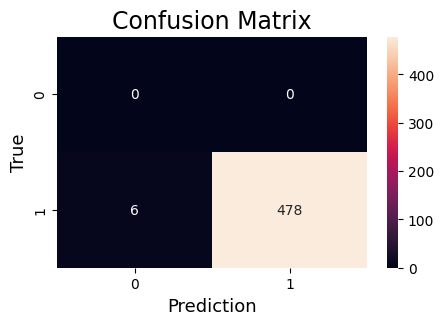

array([[  0,   0],
       [  6, 478]])

In [ ]:
confusion_matrix(y_true, y_pred)

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, neg_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.9620535714285714

0.9709821428571429


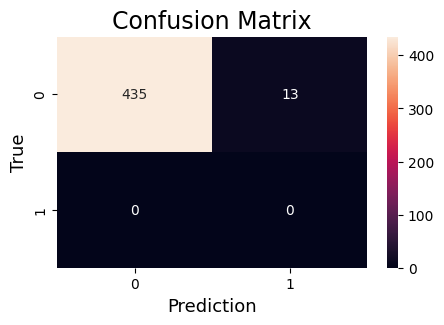

array([[435,  13],
       [  0,   0]])

In [ ]:
confusion_matrix(y_true, y_pred)

# show

0.987603305785124


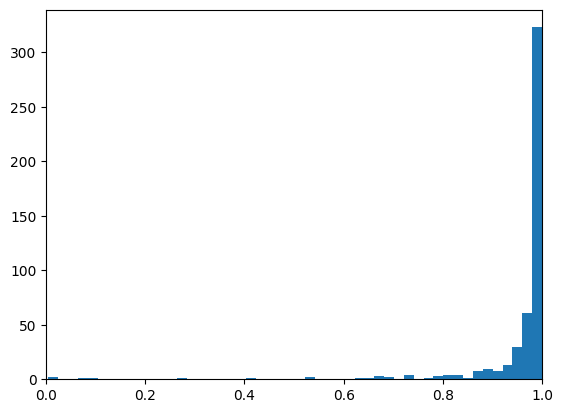

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, pos_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9896694214876033

0.9709821428571429


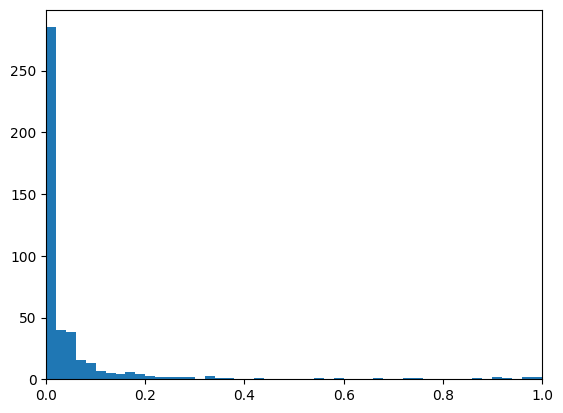

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, neg_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9754464285714286

prob > 0.8
count : 461 out of 484
pic idx : [0, 1, 2, 3, 4, 5, 6, 7]


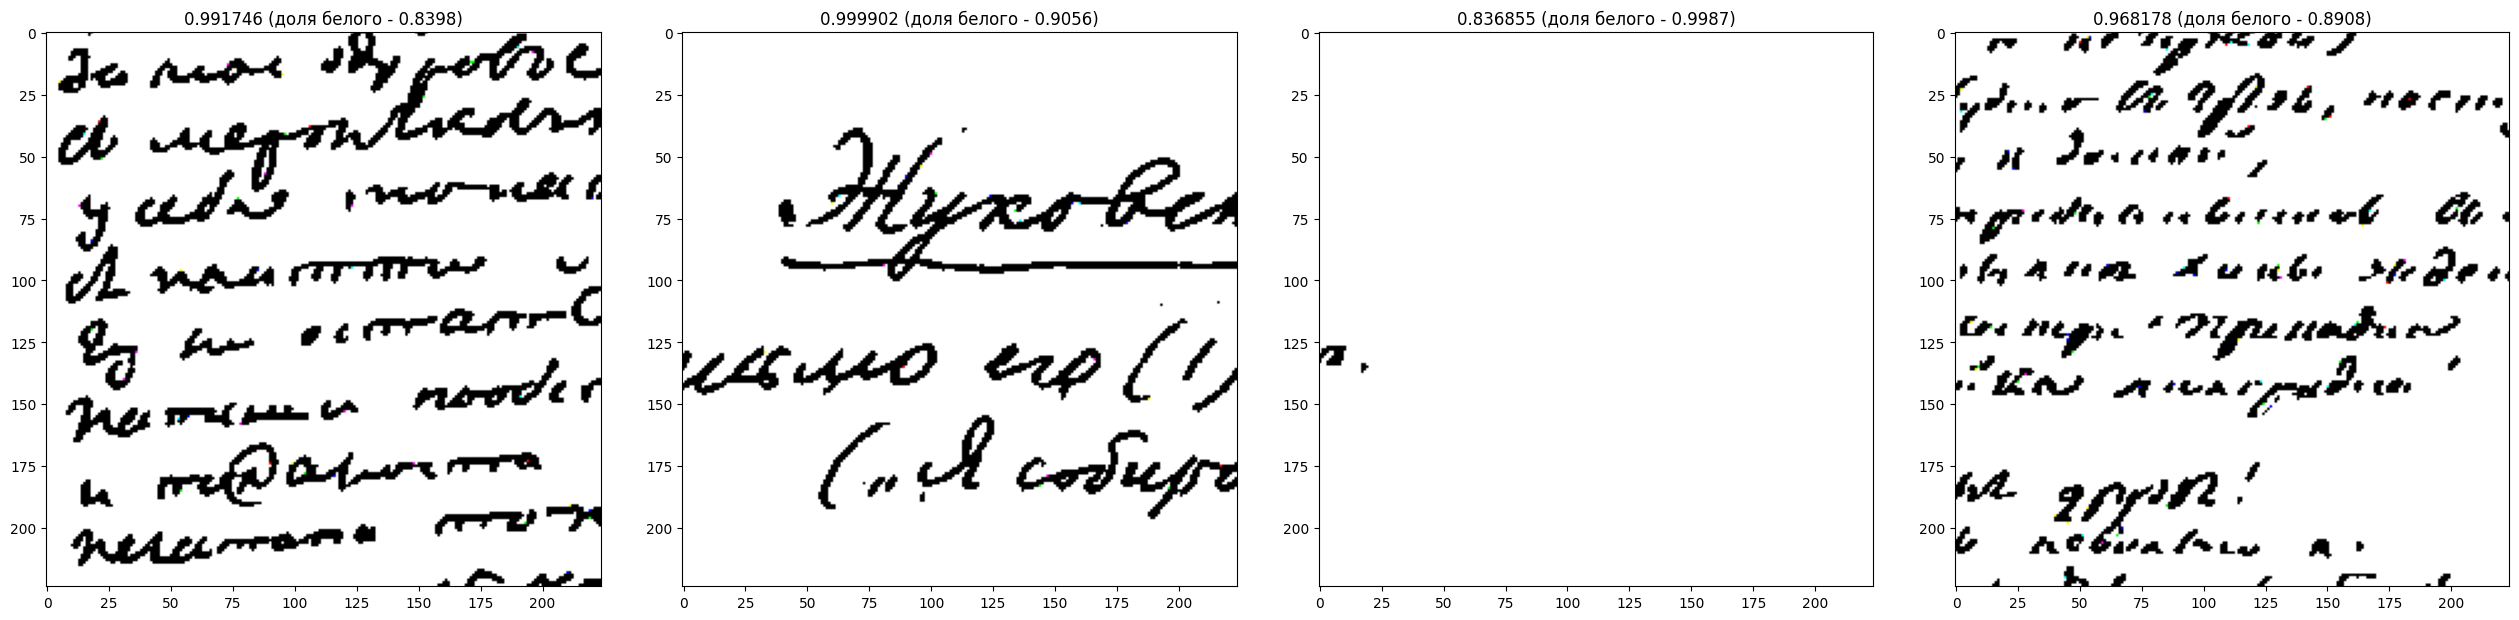

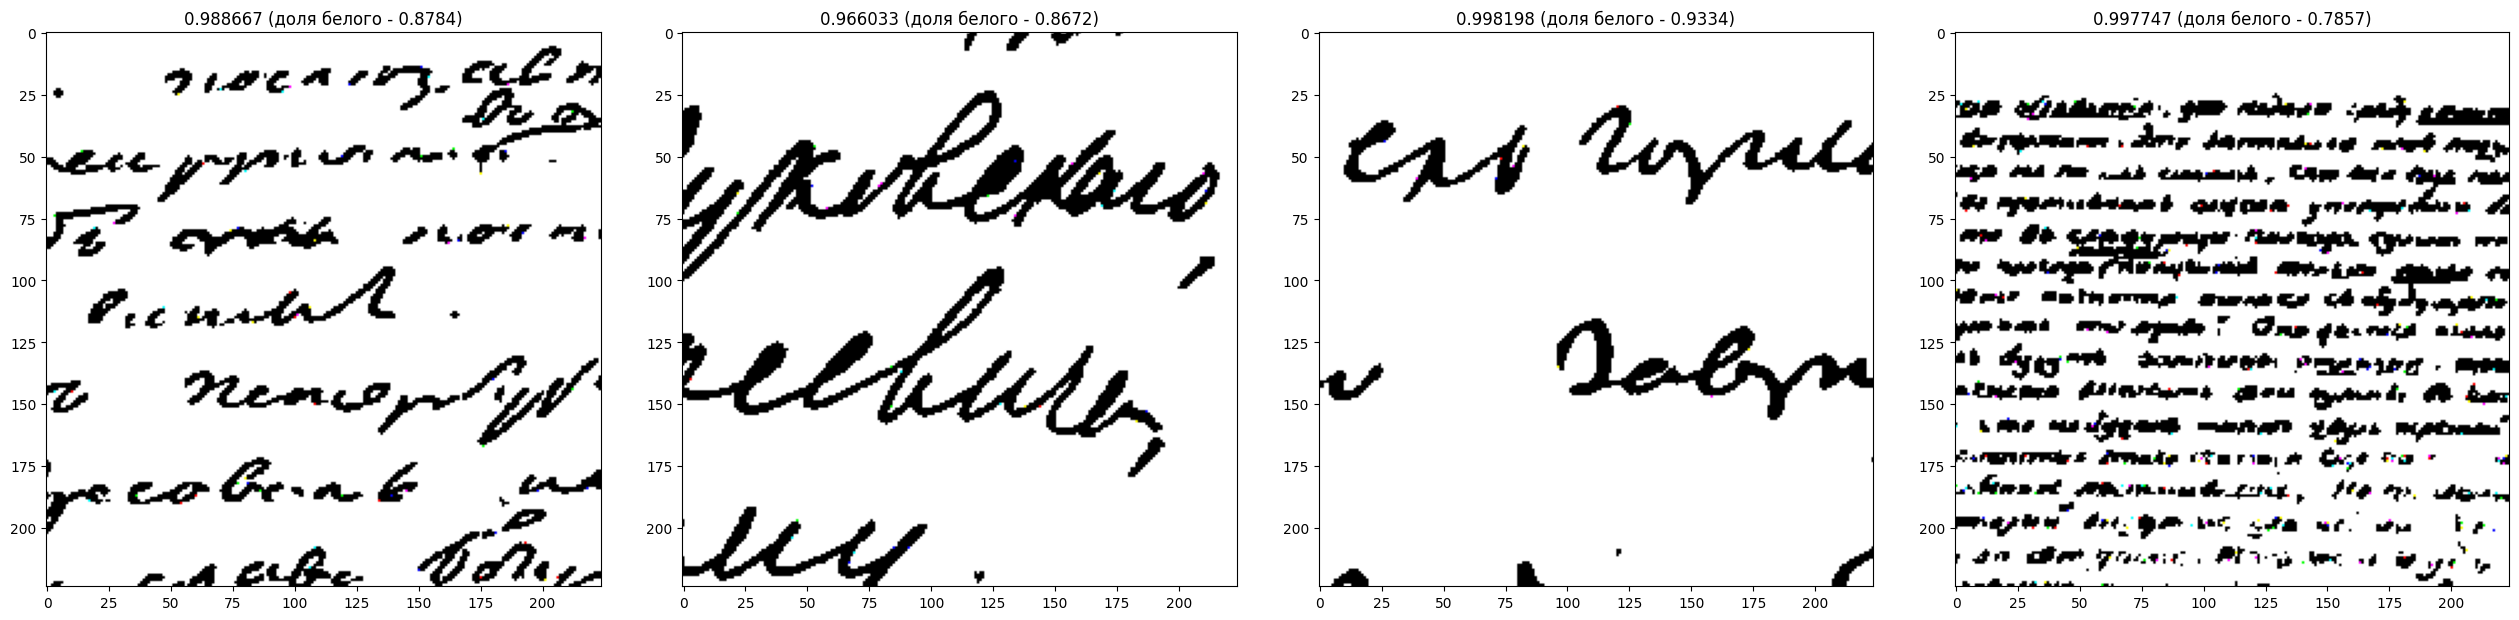

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0.8,
                                   CONF.loader.batch_size, CONF.device,
                                   greater=True, col = 8)

prob < 0.6
count : 8 out of 484
pic idx : [86, 183, 223, 260, 297, 407, 451, 473]


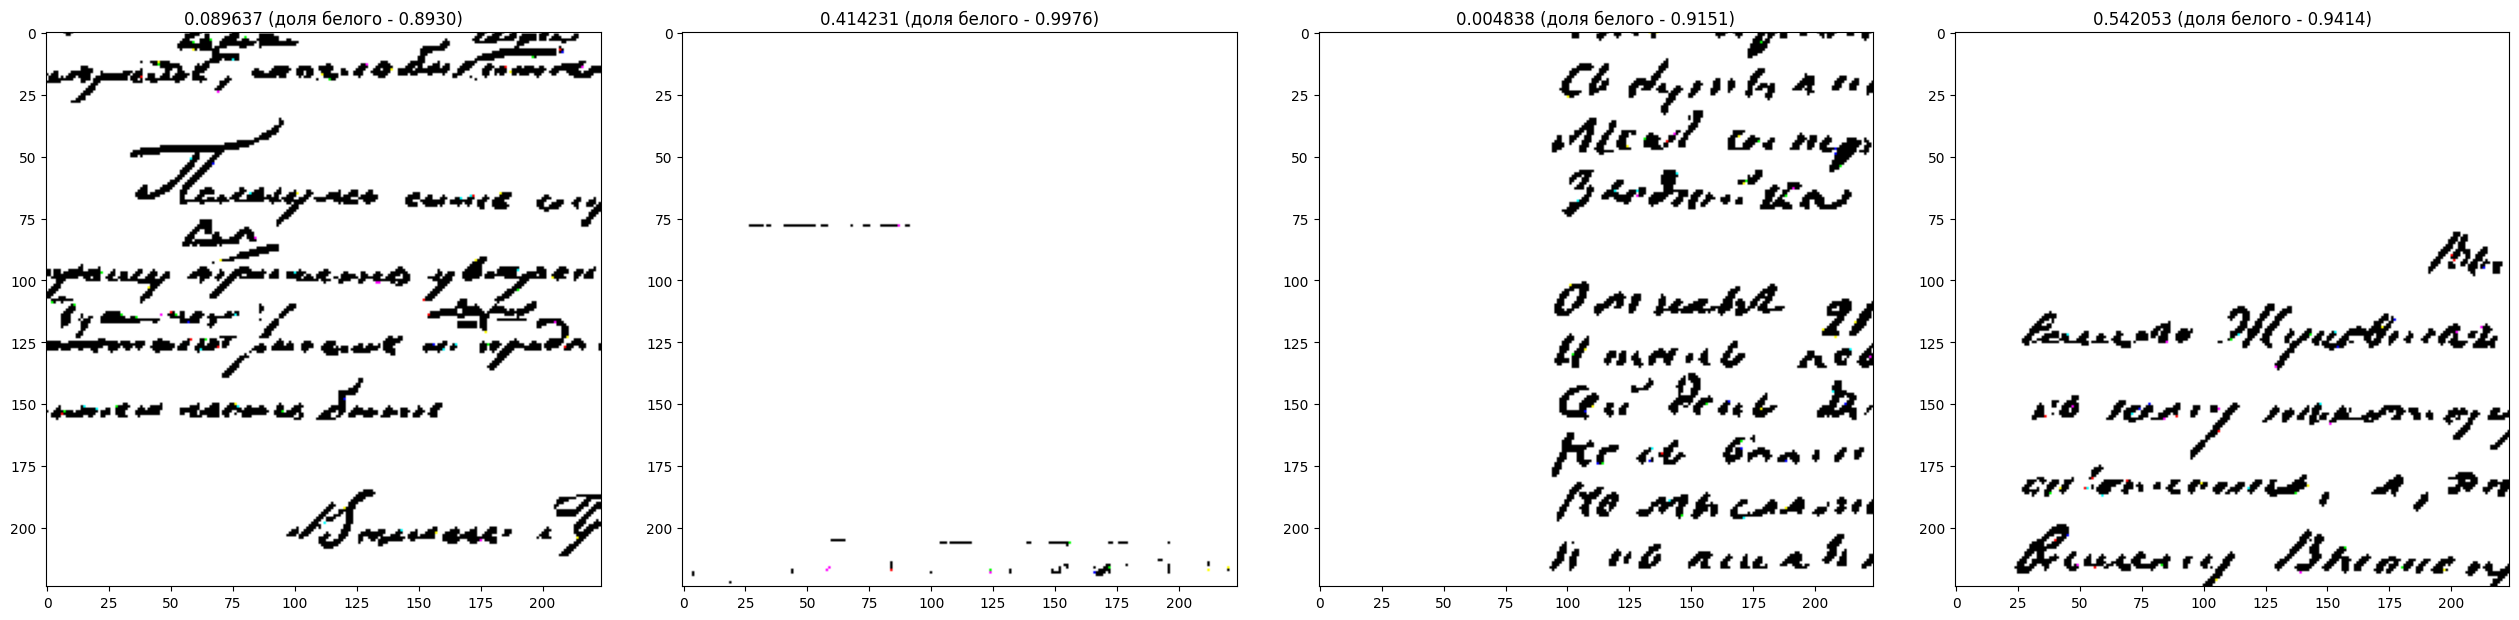

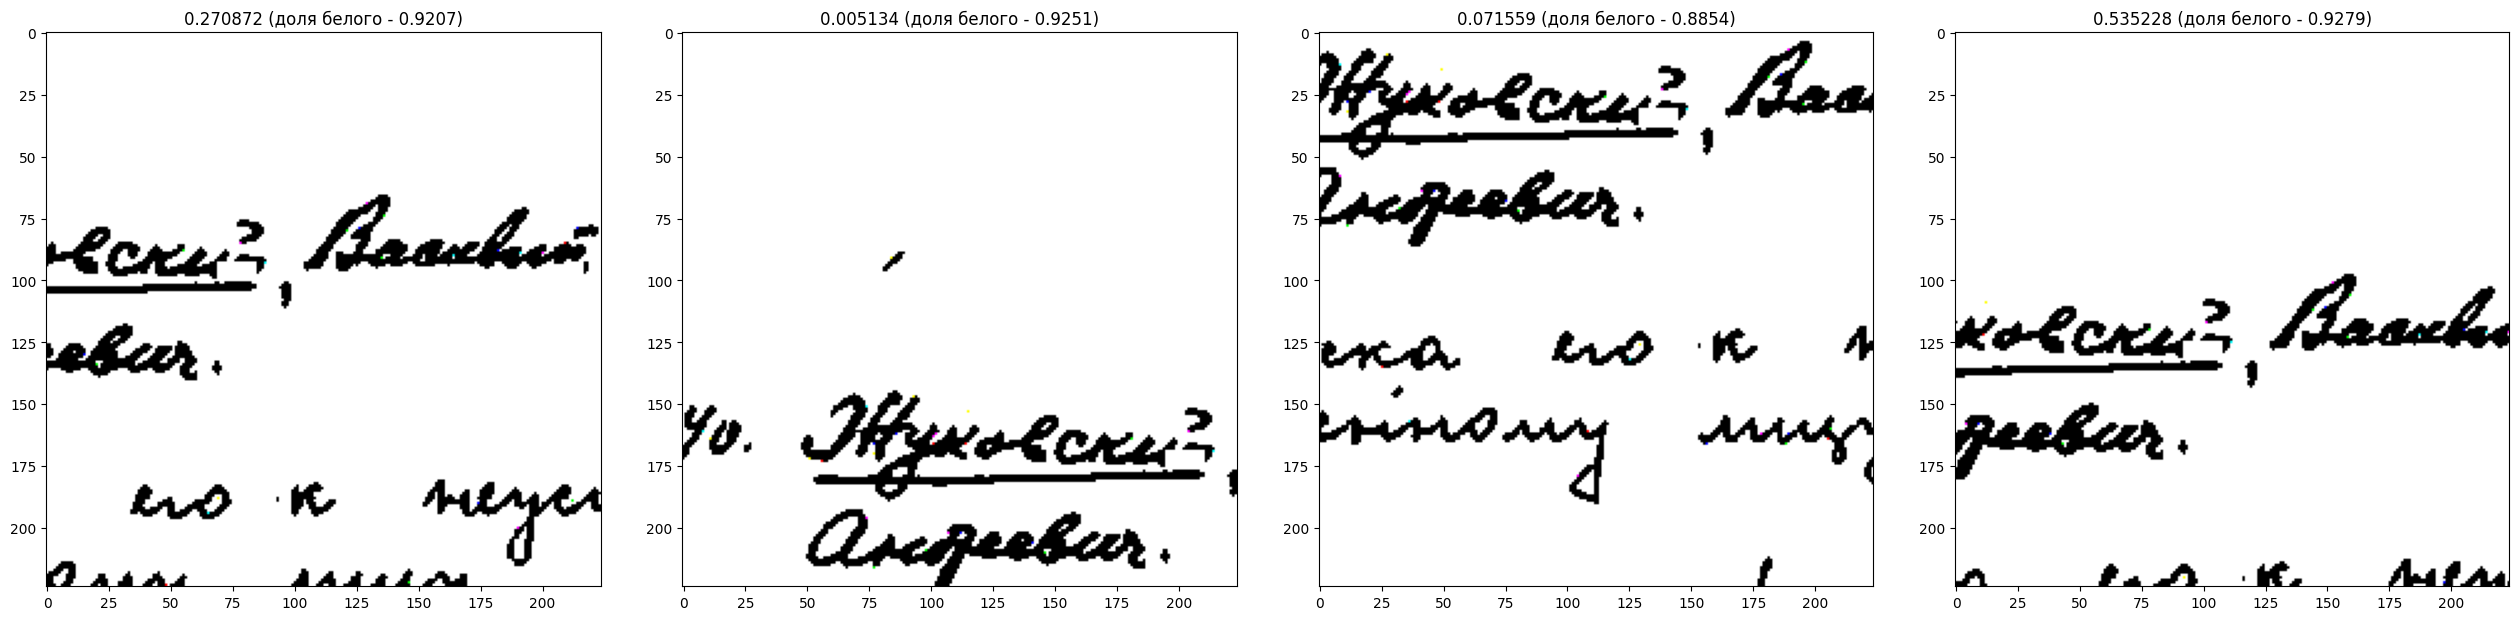

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0.6,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = False, col = 8)

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0.3,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = False, col = 24)

Output hidden; open in https://colab.research.google.com to view.

prob > 0.4
count : 14 out of 448
pic idx : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


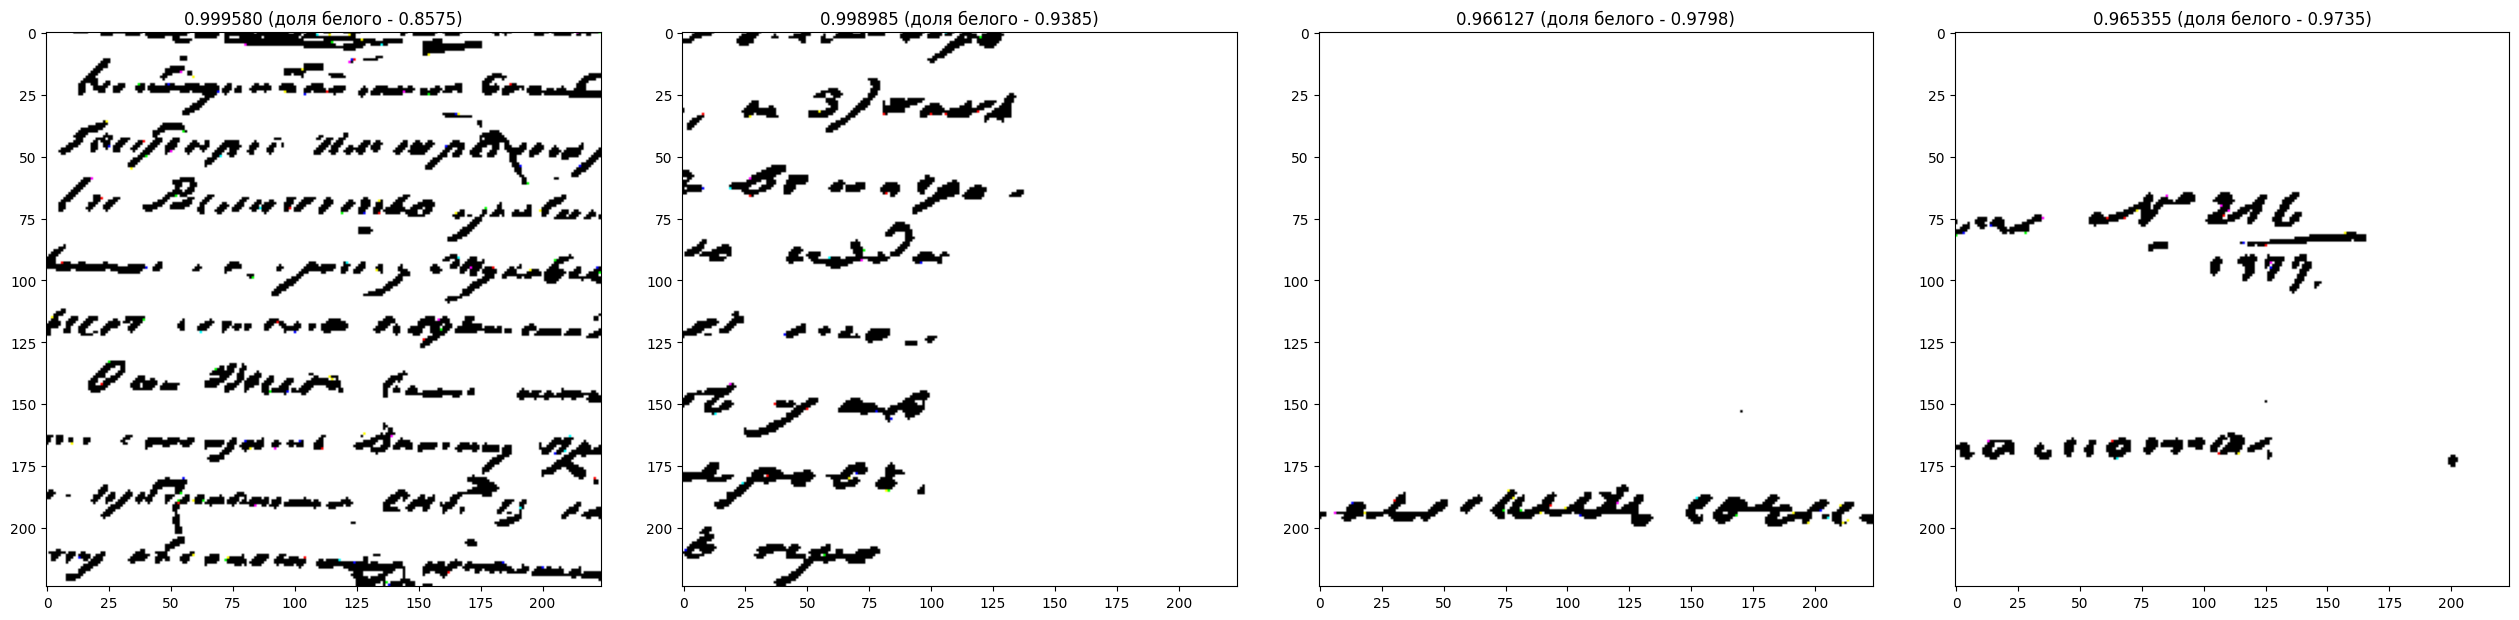

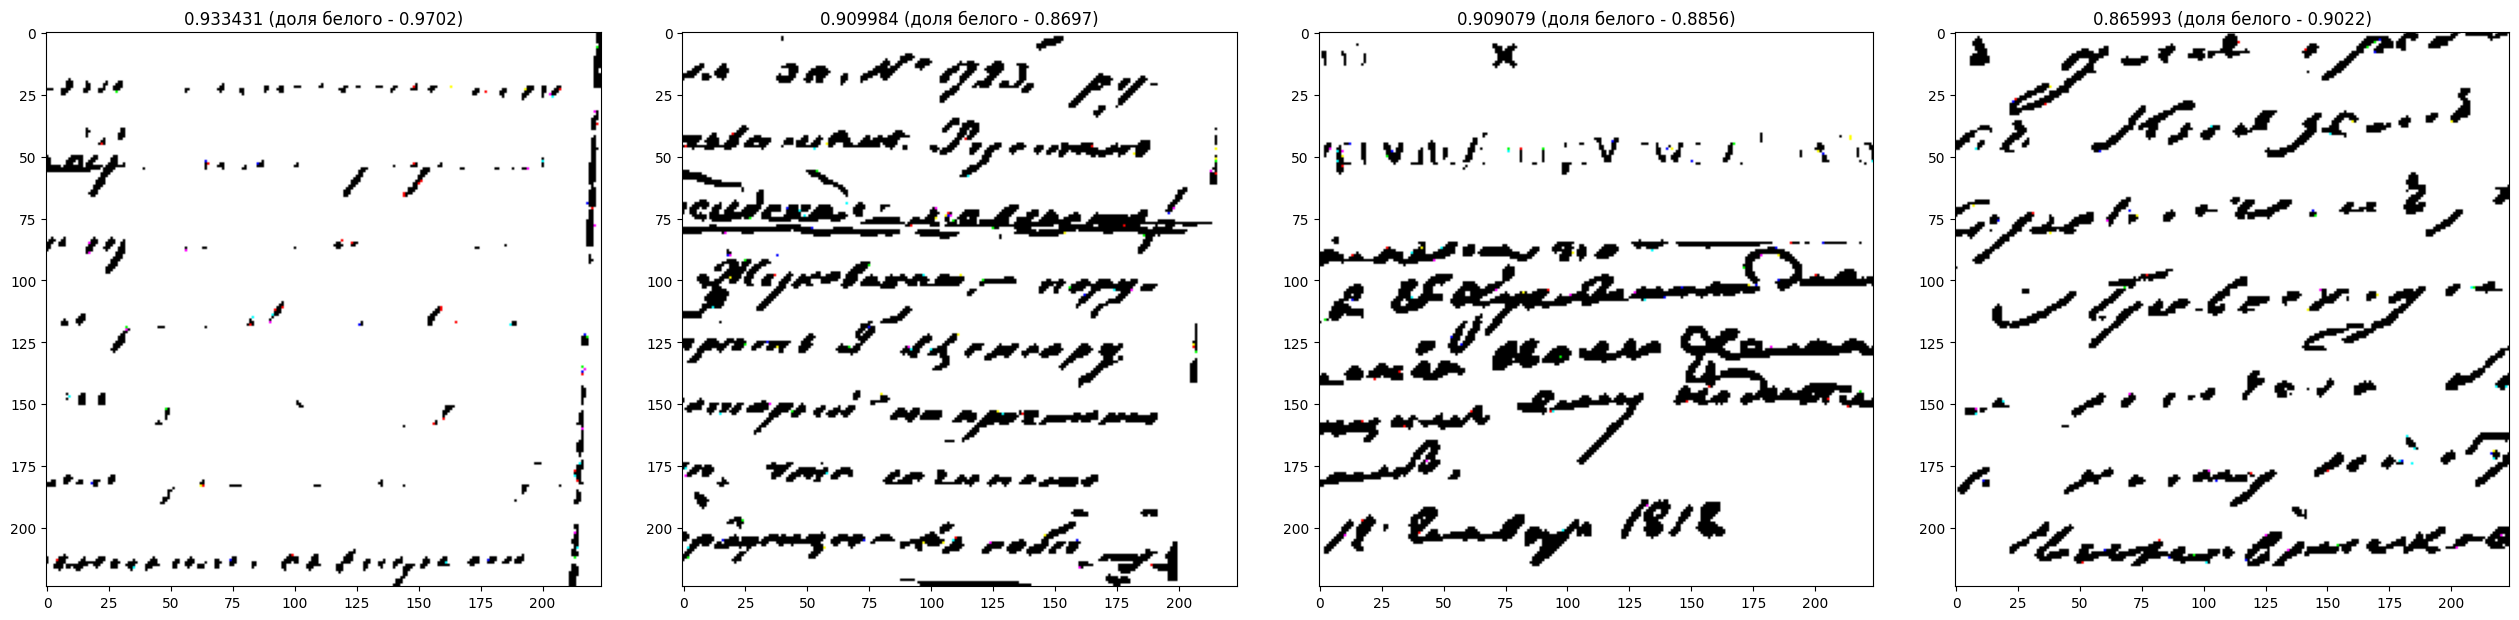

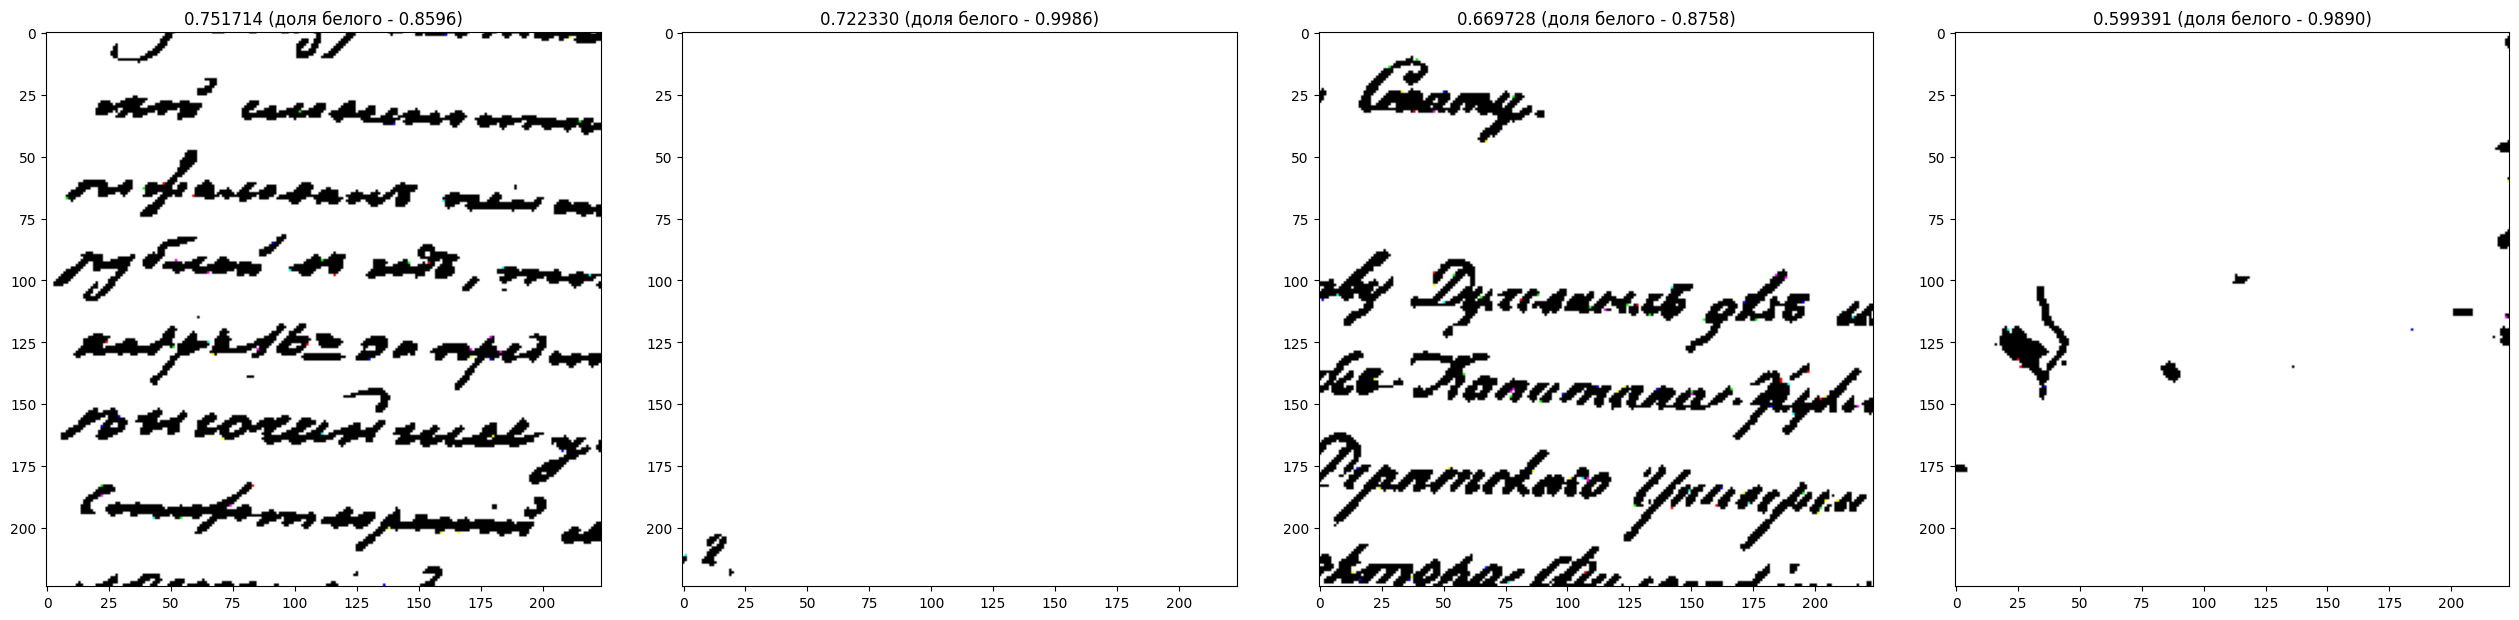

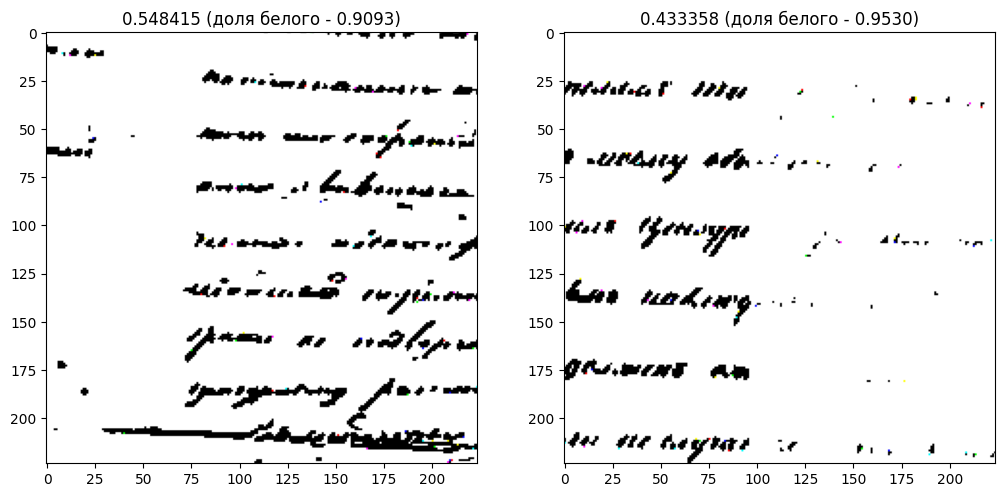

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0.4,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 24,
                                   sort = True)

In [ ]:
# img = pos_dataset[0][0]
# img.shape

In [ ]:
# s = set()
# for i in range(300):
#     for j in range(300):
#         s |= {tuple(img[:, i, j].tolist())}

# s

In [ ]:
# x, num = np.unique(img.max(dim = 0)[0], return_counts = True)
# x, num

In [ ]:
# plt.figure(figsize=(20, 20))

# plt.imshow(np.transpose(img, (1, 2, 0)))

# on the entire dataset

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 224,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 224,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.